## Summary

|     | Count Vectorizer | TF-IDF | Word2vec | Word2vec with tf-idf
| --- | --- | --- | --- | --- |
LR | 24.8% | 24.6% | 21.1% | 21.1%
NB | 25.2% | 24.7% | 18.7% | 18.1%
SVM | 24% | 24.5% | 23.7% | 23.6%



# Import Packages

In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict
import re
import json
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from gensim.models.word2vec import Word2Vec

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split



# Import Cleaned Data

In [ ]:
data_clean = pd.read_csv('data_clean.csv')
data_clean.sample(frac=1)
Characters_per_rank = (data_clean.Characters.value_counts()).index 
data_clean = data_clean[:20000]
data_clean.shape

(20000, 6)

In [ ]:
# Select and Label Dataset for Modeling

In [ ]:
threshold = 7
names={0:'MONICA', 1:'JOEY', 2:'CHANDLER', 3:'PHOEBE',4:'RACHEL',5:'ROSS',6:'Others'}
names_rev={'MONICA':0, 'JOEY':1, 'CHANDLER':2, 'PHOEBE':3,'RACHEL':4,'ROSS':5,'Others':6}

data_thres = data_clean
data_thres['Characters']= data_clean['Characters'].apply(lambda x: 'Others' if (x not in names.values()) else x)

data_thres['target'] = data_thres.apply(lambda x: names_rev.get(x.Characters),axis=1)
data_thres[:10]

,Unnamed: 0,Episodes,Episode_Names,Characters,Lines,Season,target
0,0,101,Monica Gets A Roommate,MONICA,there's nothing tell he's guy work,1,0
1,1,101,Monica Gets A Roommate,JOEY,c'mon go guy there's gotta something wrong,1,1
2,2,101,Monica Gets A Roommate,CHANDLER,right joey nice hump hump hairpiece,1,2
3,3,101,Monica Gets A Roommate,PHOEBE,wait eat chalk,1,3
4,4,101,Monica Gets A Roommate,PHOEBE,cause want go go carl oh,1,3
5,5,101,Monica Gets A Roommate,MONICA,okay everybody relax even date two people go d...,1,0
6,6,101,Monica Gets A Roommate,CHANDLER,sound like date,1,2
7,7,101,Monica Gets A Roommate,CHANDLER,alright i'm back high school i'm stand middle ...,1,2
8,8,101,Monica Gets A Roommate,Others,oh yeah dream,1,6
9,9,101,Monica Gets A Roommate,CHANDLER,look realize there's phone,1,2


In [ ]:
# split the clean text in the rows  into list of words
tokenized_data = data_thres["Lines"].apply(lambda text: re.split(' ',text))

target_thres = data_thres['target'] 
my_tags = data_thres['Characters'].unique()
my_tags

array(['MONICA', 'JOEY', 'CHANDLER', 'PHOEBE', 'Others', 'ROSS', 'RACHEL'],
      dtype=object)

In [ ]:
data_thres.head()

,Unnamed: 0,Episodes,Episode_Names,Characters,Lines,Season,target
0,0,101,Monica Gets A Roommate,MONICA,there's nothing tell he's guy work,1,0
1,1,101,Monica Gets A Roommate,JOEY,c'mon go guy there's gotta something wrong,1,1
2,2,101,Monica Gets A Roommate,CHANDLER,right joey nice hump hump hairpiece,1,2
3,3,101,Monica Gets A Roommate,PHOEBE,wait eat chalk,1,3
4,4,101,Monica Gets A Roommate,PHOEBE,cause want go go carl oh,1,3


# Feature Engineering using TF-IDF

## TFIDF

In [ ]:
# Create a BoW with TF-IDF Scheme 

def tfidf(data):
    tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2))

    tfidf_result = tfidf.fit_transform(data).toarray()
    tfidf_features = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
    tfidf_features.index = data.index
    return tfidf_features


tfidf_df = tfidf(data_thres['Lines'])
tfidf_df.shape

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(20000, 3953)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(tfidf_df,target_thres,test_size = 0.2,random_state =42)

x_train.shape

(16000, 3953)

## Plot Confusion Matrix

In [21]:
from sklearn.metrics import confusion_matrix
def plot_cm(y_true, y_pred, figsize=(15, 15)):
    y_true_label = [names[x] for x in y_true]
    
    y_pred_label = [names[x] for x in y_pred]
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true_label), columns=np.unique(y_true_label))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

## Saving Model to Disk

In [ ]:
import pickle
def save_model(model,filename):
  pickle.dump(model, open(filename+".sav", 'wb'))

# ML Modeling Performance with Different BoW\ Word Embedding Schemes

In [ ]:
def word_embedding_performance_eval(clf,X,Y):
    Eval_score =  cross_val_score(clf,X,Y, cv=5)
    return  Eval_score.mean() 
    
model =  LogisticRegression(max_iter = 1e6)
LR_Count_Vector = word_embedding_performance_eval(model,x_train,y_train)
LR_Count_Vector

0.23900000000000002

## Accuracy for Logistic Regression

In [ ]:
from sklearn.metrics import accuracy_score
model_lr =  LogisticRegression(max_iter = 1e6)
model_lr.fit(x_train,y_train)
save_model(model_lr,"tfidf-lr-frnds")
y_pred = model_lr.predict(x_test)
accuracy_score(y_test, y_pred)

0.24625

In [ ]:
from sklearn.metrics import roc_auc_score
y_prob = model_lr.predict_proba(x_test)
roc_auc_score(y_test, y_prob, multi_class="ovr",average="macro")

0.6322884650905168

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[180,  84, 153,  58, 163, 131,  77],
       [ 75, 233, 141,  59, 114, 134,  62],
       [127, 120, 254,  59, 126, 127,  73],
       [ 94,  90, 134, 146, 160,  90,  67],
       [118,  82, 142,  85, 293, 110,  93],
       [ 88, 129, 158,  67, 144, 265,  69],
       [119, 104, 141,  62, 140, 113, 147]])

In [ ]:
y_true_label = [names[x] for x in y_test]
y_true_label

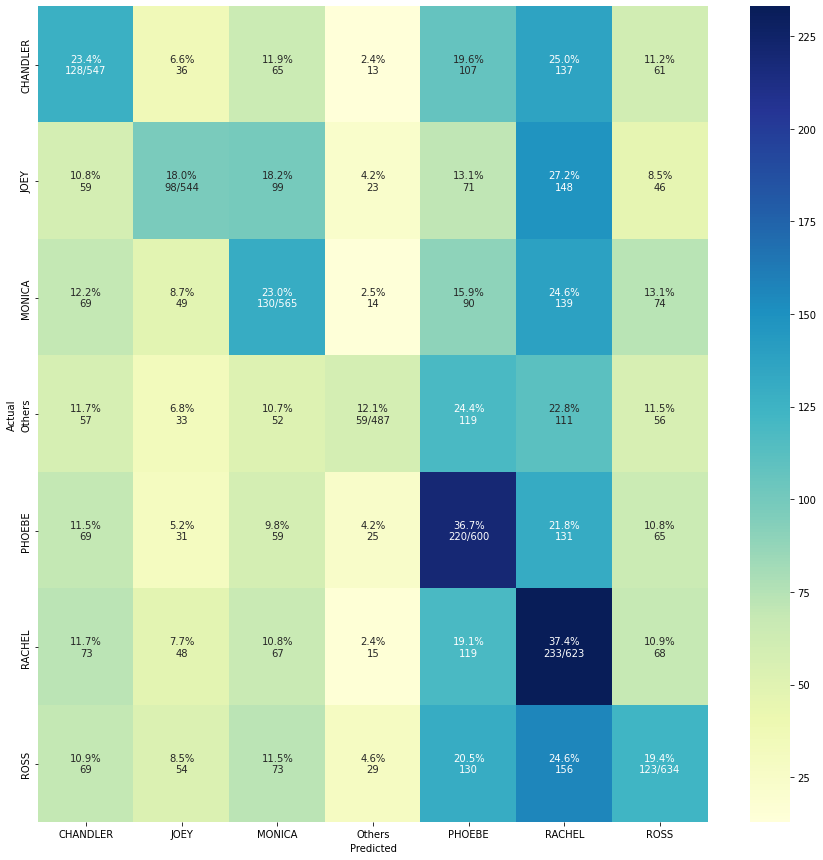

In [ ]:
plot_cm(y_test, y_pred)

## Naive Bayes with TF-IDF

In [ ]:

model = MultinomialNB()
print(cross_val_score(model,x_train,y_train, cv=5).mean())

0.232875


In [ ]:
# GridSearch with Naive Bayes
def gridsearchNB(clf, X, y):

    #the grid of parameters to search over
    alphas = [0.001,0.01,.1, 1, 5, 10, 50]

    #Find the best value for alpha and min_df, and the best classifier
    best_alpha = None
    maxscore=-np.inf
    for alpha in alphas:        
        clf = MultinomialNB(alpha=alpha)
        cvscore = max(cross_val_score(clf, X,y,cv = 5))
        if cvscore > maxscore:
                maxscore = cvscore 
                best_alpha = alpha
    return  best_alpha, maxscore

print("Best Case with Count Vectorizer: ", gridsearchNB(model,tfidf_df, target_thres))

Best Case with Count Vectorizer:  (1, 0.22125)


# Accuracy  for Navie Bayes

In [ ]:
from sklearn.metrics import accuracy_score
model_nb = MultinomialNB(alpha=1)
model_nb.fit(x_train,y_train)
y_pred = model_nb.predict(x_test)
save_model(model_nb,"tfidf-nb-frnds")
accuracy_score(y_test, y_pred)

0.24775

#ROC

In [ ]:
from sklearn.metrics import roc_auc_score
y_prob = model_nb.predict_proba(x_test)
roc_auc_score(y_test, y_prob, multi_class="ovr",average="macro")

0.6321244460456964

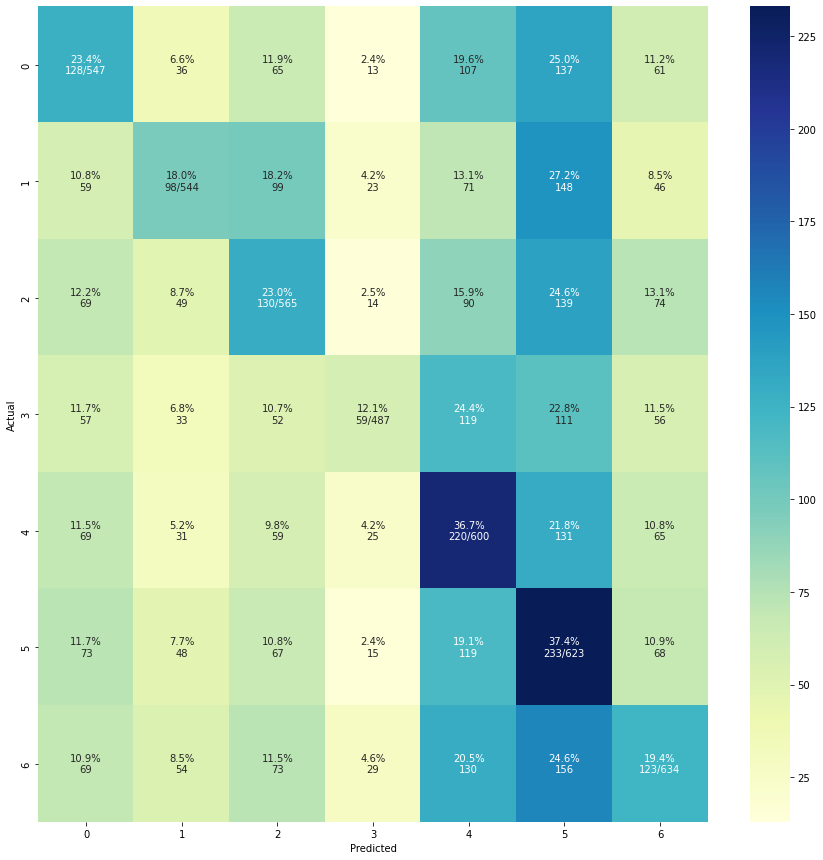

In [ ]:
plot_cm(y_test, y_pred)

## Support Vector Machine: 

In [ ]:
model_svc =SVC()
print('Accuracy of Support Vector Machine without Gridsearch:', cross_val_score(model_svc,x_train,y_train, cv=5).mean())

Accuracy of Support Vector Machine without Gridsearch: 0.24300000000000002


In [ ]:
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
#kernels =  ['rbf','linear']
params_svc = {'C': Cs, 'gamma' : gammas}
grid_svc = GridSearchCV(SVC(), param_grid = params_svc, cv=5)
grid_svc.fit(x_train,y_train)
print('Optimized Modeling Paramters for Support vector Machine', grid_svc.best_params_)
print('Accuracy of Support Vector Machine with Gridsearch:', grid_svc.best_score_)

In [ ]:
from sklearn.metrics import accuracy_score
model = SVC(probability=True)
model.fit(x_train,y_train)
save_model(model,"tfidf-nb-frnds")
y_pred = model.predict(x_test)
accuracy_score(y_test, y_pred)

0.24525

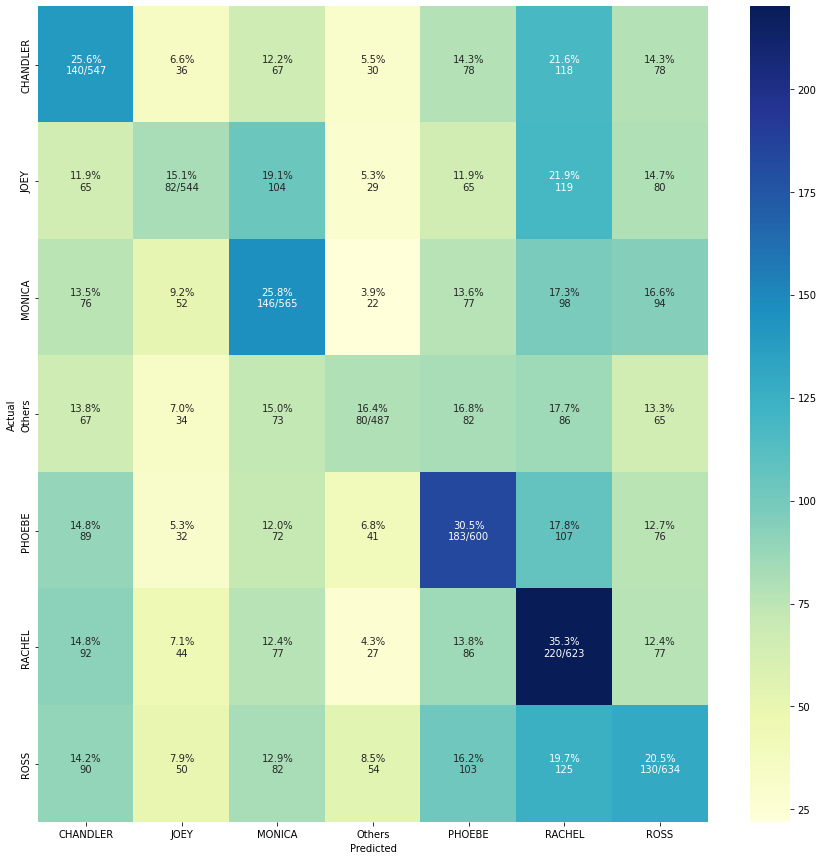

In [22]:
plot_cm(y_test, y_pred)

In [ ]:
from sklearn.metrics import roc_auc_score
y_prob = model.predict_proba(x_test)
roc_auc_score(y_test, y_prob, multi_class="ovr",average="macro")

0.6269291790459962